# How safe is it to socialize?

OK, we are all tired of hearing about social distancing. Me too. I live completely alone, with but a trusty hedgehog and an untrustworthy dog to keep me company. Recently, I found myself in a room that I felt was more crowded than I felt comfortable with given the November COVID surge. However, I rapidly realized I don't have a good sense for how bad it is to be in a crowded room. How crowded is too crowded?

So, I decided to answer this question. For this blogpost, I assume that:

a) All COVID cases are randomly uniformly distributed.
b) A person only comes into contact with a person if they are within a well-defined distance (say, the same room for more than 45 minutes)
c) The period of time a COVID positive individual is infectious is 10 days.
d) Nobody knows they have COVID.
e) Except for me. I *know* I don't have COVID.

Given these assumptions, we can calculate the probability that a random person has COVID by summing over the number of cases reported in a state (Mass.) normalized to that states population for the last 10 days:

$$
P(\text{random person has COVID at time, }t) = \sum_{i = t-10}^{t}\text{Reported Cases per person}_i
$$

Then, if you are in a room with $N$ people, we are interested in the probability that none of those $N$ individuals have COVID:

$$
P(\text{None of N individuals have COVID at time } t) = [1 - P(\text{random person has COVID at time, } t)]^N.
$$

With the above equation, we can now begin to think about our safety. Suppose that every time I want to enter a room, I wish to be 95% confident that nobody has COVID. Using the equation above, I can simply find the largest $N$ such that the probability that nobody in that room has COVID is greater than 95%. In the code below, I simulate exactly that question:


In [1]:
import datetime as dt
today = dt.datetime.now() 
print('This notebook was last updated on', today.strftime('%A %B %d, %Y at %H:%M'))   

This notebook was last updated on Monday November 16, 2020 at 19:21


In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

sys.path.append('./utils')

# see https://github.com/dangeles/dangeles.github.io/blob/master/jupyter/utils/covid_utils.py
import covid_utils as cv 

## First, we load the NYT data and normalize it to the per state population:

In [3]:
# load into a dataframe:
pop = pd.read_excel('../data/nst-est2019-01.xlsx', comment='#', header=1)

# fetch NYT data:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
df = pd.read_csv(url, usecols=[0, 1, 3, 4], parse_dates=['date'], squeeze=True)

pop.columns = np.append(np.array(['state']), pop.columns[1:].values)
pop.state = pop.state.str.strip('.')

# merge dfs:
df = df.merge(pop, left_on='state', right_on='state')
# calculate per population numbers:
df['normedPopCases'] = df.cases/ df[2019]

## Plot:

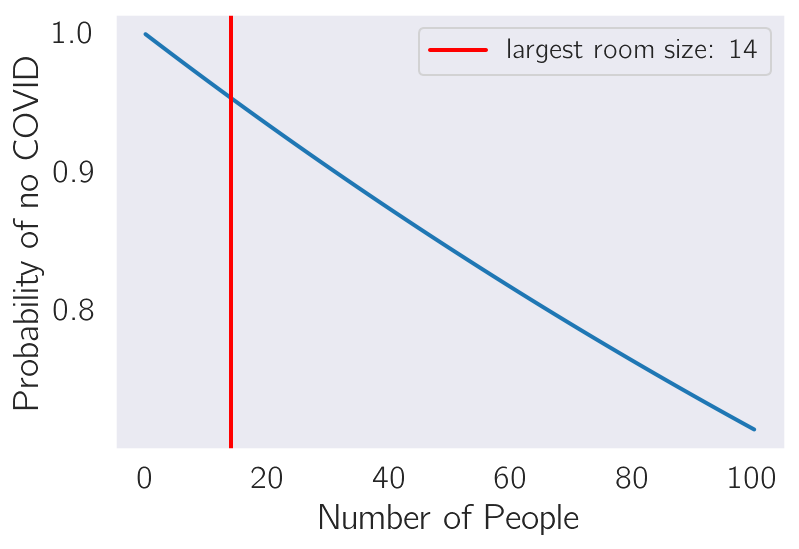

In [4]:
def safety(p_covid, N):
    """Log of probability nobody has COVID in a room full of N people"""
    return N * np.log(1 - p_covid)

x = np.linspace(0, 100)

state = 'Massachusetts'
p_covid = df[df.state == state].normedPopCases.diff().values[-10:].sum()

y = np.exp(safety(p_covid, x))
n = int(np.round(x[np.where(y > .95)[0][-1]]))

plt.plot(x, y)
plt.axvline(n, color='red', label = 'largest room size: {0}'.format(n))
plt.legend()

plt.xlabel('Number of People')
_ = plt.ylabel('Probability of no COVID')

## What if I wanted to know how many people I can meet per day in order to keep a 95% safety profile every week?

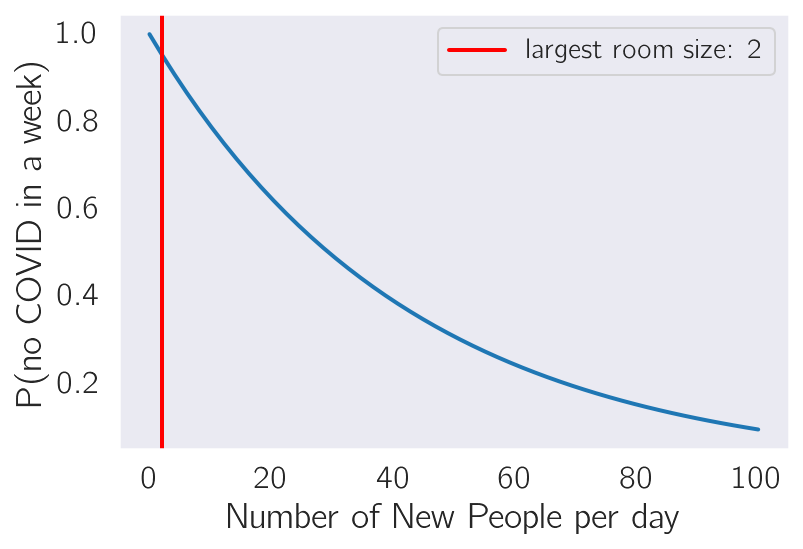

In [5]:
def weekly_safety(p_covid, number):
    return 7 * number * np.log(1 - p_covid)

x = np.linspace(0, 100)

state = 'Massachusetts'
p_covid = df[df.state == state].normedPopCases.diff().values[-10:].sum()

y = np.exp(weekly_safety(p_covid, x))
n = int(np.round(x[np.where(y > .95)[0][-1]]))

plt.plot(x, y)
plt.axvline(n, color='red', label = 'largest room size: {0}'.format(n))
plt.legend()

plt.xlabel('Number of New People per day')
_ = plt.ylabel('P(no COVID in a week)')

## How has my safety fluctuated this week, if every day I interact with two new people?

Mean safety profile over this year if meeting 2 people a day every day:
0.99815


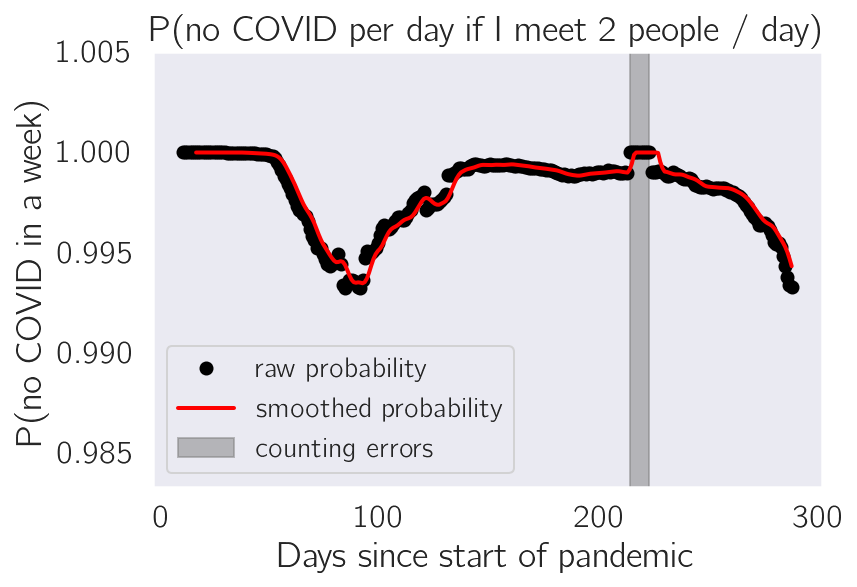

In [6]:
p_covid = df[df.state == state].normedPopCases.diff().rolling(10).sum()
smooth_p_covid = df[df.state == state].normedPopCases.rolling(window=7,
                                                              win_type='gaussian',
                                                              center=False).mean(std=2
                                                              ).diff().rolling(10).sum()

y = np.exp(safety(p_covid, 2))
y_smooth = np.exp(safety(smooth_p_covid, 2))
error = np.where(y > 1)[0]
y[y > 1] = 1
y_smooth[y_smooth > 1] = 1

plt.plot(y.values, 'o', label='raw probability', color='black')
plt.plot(y_smooth.values, label='smoothed probability', color='red')
plt.fill_between(error, 1.05, alpha=0.5, color='gray', label='counting errors')

plt.legend()
plt.ylim(np.min(y)*0.99, 1.005)
plt.xlabel('Days since start of pandemic')
plt.ylabel('P(no COVID in a week)')
_ = plt.title('P(no COVID per day if I meet {0} people / day)'.format(n))

print('Mean safety profile over this year if meeting 2 people a day every day:')
print('{0:.5g}'.format(y_smooth.mean()))

Notice how safe each individual day is on average! Even at the height of the pandemic, each day is, relatively speaking, quite safe!

# How safe is "safe"?

Well, so far we've established that from the beginning of the pandemic to date, I have met 2 people a day every day, how safe have I been?

The answer for this is also easier to compute. Assuming I meet new people every day, then each day is independent from each other. Independent probabilities multiply. So I can take the probabilities above and multiply them to get my answer:

In [7]:
np.product(y_smooth)

0.6028646303870226

The number above is the probability that I have not come into contact with a single infectious individual this year if I hung out with 2 new people every day of the pandemic to date. Clearly, my safety to date if I met 2 people each day is quite far from a 95% "safety" profile!

How safe would I have to be to be sure that I had a 95% safety profile over the year? Then, we wish to solve the equation:

$$
0.95 = p ^ {52}
$$

In [8]:
0.95 ** (1 / 52)

0.9990140768344814

I would have to keep a 99.9% safety profile. That means, if I wanted to avoid any infectious exposure, most days of 2020 I would have to... socially distance! Most days, we should NOT be meeting new people! Remember, here, new people means the people that you do not spend 100% of your life with. 

**Stay safe, everyone**.